# 2. Data Exploration

In [2]:

# Importing packages
import pandas as pd
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer
import statsmodels.api as sm

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
#test_df.describe()

In [5]:
#train_df.describe()

In [6]:
print('The number of observations is: {}'.format(train_df.shape[0]))
print('The number of independent variables is: {}'.format(train_df.shape[1] - 1))

The number of observations is: 1460
The number of independent variables is: 80


## Dependent Variable: 

At first, we want to explore the dependent variable which is 'SalePrice' to identify outliers and its distribution.

/Users/NhungLe/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


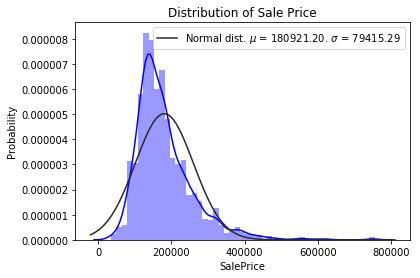

In [7]:
(mu, sigma) = norm.fit(train_df['SalePrice'])
sns.distplot(train_df['SalePrice'], fit = norm, norm_hist = True, color = 'B')
plt.legend(['Normal dist. $\mu$ = {:.2f}. $\sigma$ = {:.2f}'.format(mu, sigma)])
plt.ylabel('Probability')
plt.title('Distribution of Sale Price')
plt.show()

As shown in the graph above, we can clearly see that the sale prices are skewed right and most sale prices range from $150,00 to $200,000. In order to double check the distribution of the sale prices, I used Q-Q (Quantile - Quantile)plot to evaluate the goodness of fit of the model fitting the best fit line for the sale prices. 

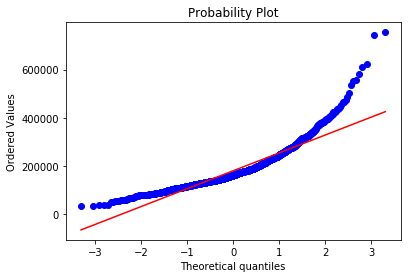

In [8]:
# #Get also the QQ-plot of Sale Price
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

Clearly, sale prices are not normally distributed. It is because the line we see represent a normal distribution where quantiles represent standard deviation; if the sale prices are normally distributed, sale prices should follow the line. 

A method to deal with skewed data is to log-transform it. Thus, I took the log of sale prices and plot the best fit line for them. Both Q-Q plot and histogram plot shown below proved that log of sale prices are normally distributed.

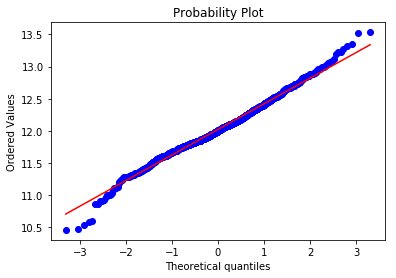

In [9]:
# #Get also the QQ-plot of Log of Sale Price
fig = plt.figure()
res = stats.probplot(np.log(train_df['SalePrice']), plot=plt)
plt.show()

From Q-Q plot, we could see that the log of sale price seems to follow a normal distribution. We will check by plotting the log of sale price.

/Users/NhungLe/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


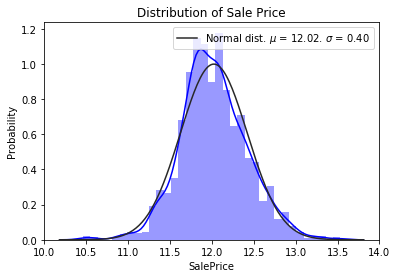

In [10]:
y = np.log(train_df['SalePrice'])
(mu, sigma) = norm.fit(y)
sns.distplot(y, fit = norm, norm_hist = True, color = 'B')
plt.legend(['Normal dist. $\mu$ = {:.2f}. $\sigma$ = {:.2f}'.format(mu, sigma)])
plt.ylabel('Probability')
plt.title('Distribution of Sale Price')
plt.show()

## Correlation between Dependent and Independent Variables

It is necessary to understand the relationship between independent variables to identify variables that mostly impact sale prices before engineering feature and building models.

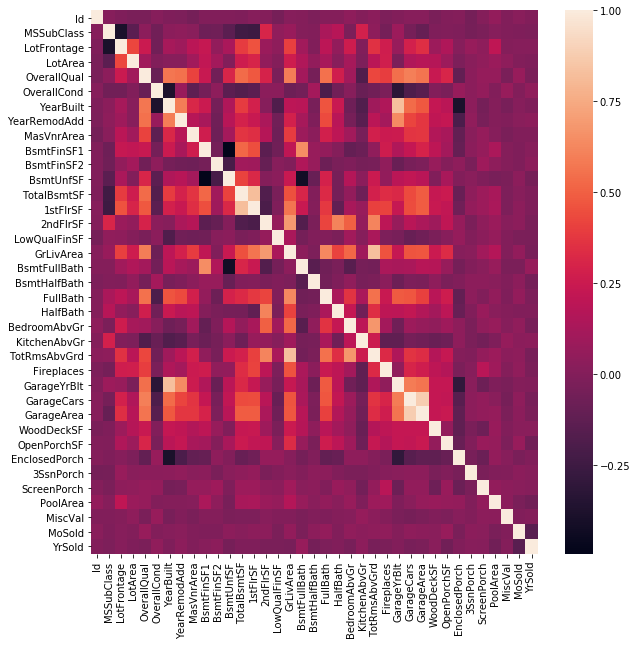

In [11]:
plt.figure(figsize = (10,10))
sns.heatmap(train_df.iloc[:, 0:80].corr())
plt.show()

Since it is hard to identify strongly correlated variables, it is better to have correlation value for each pair of variables.

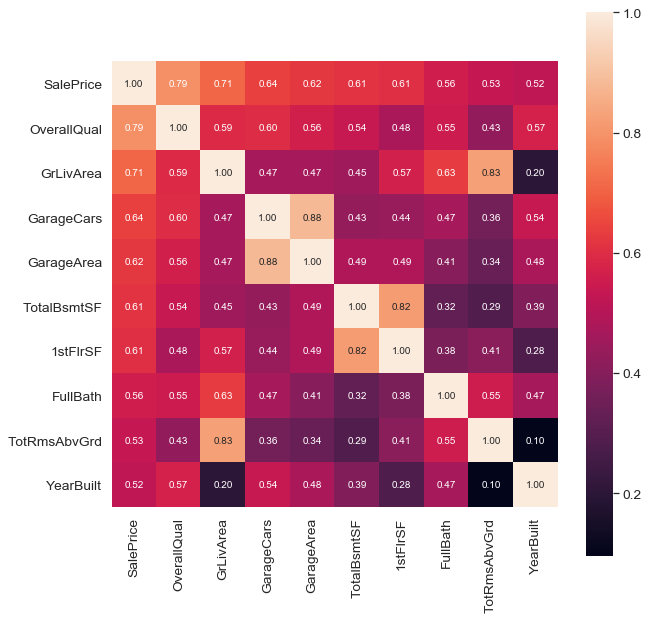

In [12]:
k = 10 #number of variables for heatmap
plt.figure(figsize = (10,10))
corrmat = train_df.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

The heatmap above demonstrates some important points:
    1. OverallQual, GrLivArea, and GarageCars are strongly correlated with SalePrice. 
    2. OverallQual is strongly related with GarageCars, GrLivArea, and YearBuilt. Thus, the three variables GarageCars, GrLivArea, and YearBuilt may also affect SalePrice. 
    3. GrLivArea is strongly correlated with 1stFlrST (First Floor square feet) and TotRmsAbvGrd (Total rooms above grade (does not include bathrooms)). These two variables also correlate with SalePrice. 
    4. GarageCars is highly correlated with GarageArea, suggesting that area of garage also influences SalePrice, knowing that GarageCars is strongly correlated with SalePrice. However, given the strong corrrelationship between the two variables, we should only keep one variable, which is GarageCars which has higher correlationship with SalePrice.
    5. TotalBsmtSF and 1stFlrSF are also highly correlated so we will only keep one of the two as an independent variable to predict SalePrice. 
    6. TotRmsAbvGrd is significantly correlated with GrLivArea, so we will also select one of the two, which is GrLivArea whichh as higher correlation with SalePrice. 

## Aggregating Data

In order to fully explore and engineer data, we would combine train and test datasets.

In [13]:
#train_df['Type'] = 'Train'
#test_df['Type'] = 'Test'
test_df['SalePrice'] = np.nan

In [14]:
#sorted(test_df.columns.values)
train_size = train_df.shape[0]
test_size = test_df.shape[0]

In [15]:
print('train data has: {}'.format(len(train_df.columns)))
print('test data has: {}'.format(len(test_df.columns)))
print('train data and test data has the same columns: {}'.format(sorted(train_df.columns.values) == sorted(test_df.columns.values)))
#test_df.iloc[:, 81]

train data has: 81
test data has: 81
train data and test data has the same columns: True


In [16]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [17]:
train_test = pd.concat([train_df, test_df])
#train_test.columns

In [18]:
train_test.drop(['Id'], axis=1, inplace=True)

In [19]:
train_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


## Missing Data

Further investigation shows that there are 34 variables with missing data, only 11 of which has more than 5% of all data missing and worth our effort to fill in missing data. From data description, we know that:
    - NA for PoolQC means No pool, should be filled with None
    - NA for MiscFeature means no misc feature, should be filled with None
    - NA for Alley means no alley access, should be filled with None
    - NA for Fence means no fence, should be filled with None
    - NA for FireplaceQu means no fireplace, should be filled with None
    - NA for LotFrontage means missing linear feet of street connected to property value and should be filled with the LotFrontage of neighbor 
    - For features where NA indicates no such feature, missing values will be filled with None. These features includ: GarageFinish, GarageQual, GarageType, GarageCond, BsmtCond, BsmtExposure, BsmtQual, BsmtFinType2, BsmtFinType1
    - NA for GarageYrBlt will be filled with 0
    - NA for SalePrice means the SalePrice of the test set, and should not be filled with anything
    - For features with numerical values and only 1 or 2 missing values, we will fill with average value. These features include: 'BsmtFullBath', 'BsmtHalfBath', 'GarageArea', 'GarageCars', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1', 'TotalBsmtSF'
    - For features with categorical values, we will fill in missing data with most popular ones. These features include 'Functional', 'Utilities', 'Exterior2nd', 'Electrical', 'Exterior1st', 'KitchenQual', 'SaleType', 'MasVnrType', 'MSZoning'

In [20]:
nums_na = train_test.apply(lambda x: x.isnull().sum() / len(x)).sort_values(ascending = False).to_frame(name = 'Pct Missing')
nums_na = nums_na[nums_na['Pct Missing'] != 0]
nums_na.index

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'SalePrice', 'FireplaceQu',
       'LotFrontage', 'GarageCond', 'GarageYrBlt', 'GarageQual',
       'GarageFinish', 'GarageType', 'BsmtCond', 'BsmtExposure', 'BsmtQual',
       'BsmtFinType2', 'BsmtFinType1', 'MasVnrType', 'MasVnrArea', 'MSZoning',
       'Utilities', 'Functional', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars',
       'BsmtFinSF2', 'Exterior2nd', 'GarageArea', 'TotalBsmtSF', 'BsmtUnfSF',
       'BsmtFinSF1', 'Exterior1st', 'KitchenQual', 'SaleType', 'Electrical'],
      dtype='object')

In [21]:
None_replace = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 
               'GarageFinish', 'GarageQual', 'GarageType', 'GarageCond', 'BsmtCond', 'BsmtExposure', 
                'BsmtQual', 'BsmtFinType2', 'BsmtFinType1']

In [22]:
for col in None_replace: 
    train_test[[col]] = train_test[[col]].fillna('None')

In [23]:
train_test['GarageYrBlt'] = train_test['GarageYrBlt'].fillna(0)
#train_test['GarageYrBlt'].isnull().sum()

In [24]:
num_var = ['BsmtFullBath', 'BsmtHalfBath', 'GarageArea', 'GarageCars', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1', 'TotalBsmtSF', 'MasVnrArea']

In [25]:
for var in num_var: 
    mean_value = np.mean(train_test[var])
    train_test[var] = train_test[var].fillna(mean_value)

In [26]:
cat_var = ['Functional', 'Utilities', 'Exterior2nd', 'Electrical', 'Exterior1st', 'KitchenQual', 'SaleType', 'MasVnrType', 'MSZoning']

In [27]:
for var in cat_var: 
    pop_value = train_test[var].value_counts().index[0]
    train_test[var] = train_test[var].fillna(pop_value)

## Baseline model

In order to have a baseline model, we need to categorize object variables so our data is runnable. It is because Scikitlearn models (e.g., Logistic Regression, Multilinear Regression) cannot parse string values of a feature.

In [28]:
object_col = train_test.select_dtypes(include='object')
num_col = list(train_test.select_dtypes(include='int64').columns)
#object_col.drop('Type', axis = 1)
object_col = list(object_col.columns)
print(object_col)
#print(num_col)

['MSZoning', 'LotFrontage', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [29]:
base_train_test = train_test.copy()

In [30]:
#Use OneHotEncoder immediately, then PCA
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from numpy import array

In [31]:
for col in object_col: 
    label_encoder = LabelEncoder()
    base_train_test[col] = label_encoder.fit_transform(list(base_train_test[col].values))

In [32]:
base_train_clean = base_train_test[:train_size]
base_test_clean = base_train_test[train_size:]

In [33]:
#base_train_test.select_dtypes(include = 'object')

In [34]:
base_X_train = base_train_clean.drop('SalePrice', axis = 1)
base_Y_train = base_train_clean['SalePrice']
base_X_test = base_test_clean.drop('SalePrice', axis = 1)

In [35]:
import statsmodels.api as sm
model = sm.OLS(np.log(base_Y_train), base_X_train).fit() ## sm.OLS(output, input)
predictions = model.predict(base_X_train)
# Print out the statistics
brand_model = model.summary()

In [36]:
Y_pred = np.exp(model.predict(base_X_test))

In [37]:
sub = pd.DataFrame()
sub['Id'] = test_df['Id']
sub['SalePrice'] = Y_pred
sub.to_csv('LinearReg_submission.csv',index=False)

In [38]:
#print(brand_model)

## Feature engineering

After getting the baseline model, we can start engineering features: 

    1. Transform types of some variables from integer to string 
    2. Encode object variables: This parse string to number by classify object variables. 
    3. OneHotCode some categorical variables. 
        For some categorical variables, their classified groups entail information about the target variables and should be treated as numerical variables. For example, if we believe that YearSold (i.e., the year the house was sold) affects the house price, then the YearSold variable should be treated as a numerical variable. 
        For other categorical variables where classified groups do not entail information about the target variable, we should create dummy variables for these groups. For example, for RoofStyle (i.e., type of roof), group 2 (e.g., roof type = gable) does not affect the house price as twice as the group 1 (e.g., roof type = flat) does, so we should have dummy variables for RoofStyle. 

In [39]:
#May not want to categorize 'MoSold', 'YrSold'
num_cat_var = ['MSSubClass', 'OverallCond', 'OverallQual']
for var in num_cat_var:
    train_test[var] = train_test[var].astype(str)

In [40]:
train_test['TotalSF'] = train_test['1stFlrSF'] + train_test['2ndFlrSF'] + train_test['TotalBsmtSF']
train_test.drop(['1stFlrSF','2ndFlrSF', 'TotalBsmtSF'], axis = 1, inplace = True)

In [41]:
#LotFrontage should be int

In [42]:
#for col in object_col: 
#    print(col, train_test[col].value_counts())

In [43]:
object_col = train_test.select_dtypes(include='object').columns
object_col

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [44]:
object_numerical_col = ['BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtQual', 'CentralAir','Condition1', 'Condition2', 
 'Electrical', 'ExterCond', 'ExterQual',
       'Fence', 'FireplaceQu', 'GarageCond',
       'GarageFinish', 'GarageQual', 'HeatingQC', 'KitchenQual', 'LandContour', 'LandSlope', 
       'LotFrontage', 'LotShape', 'MSSubClass', 'MSZoning', 'Neighborhood', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition','Street', 'Utilities']

In [45]:
for col in object_numerical_col: 
    label_encoder = LabelEncoder()
    train_test[col] = label_encoder.fit_transform(list(train_test[col].values))

In [46]:
print('Shape of the train_test data after encoding object variables: {}'.format(train_test.shape))

Shape of the train_test data after encoding object variables: (2919, 78)


In [47]:
train_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF
0,10,3,93,8450,1,None,3,3,0,Inside,...,3,4,None,0,2,2008,WD,4,208500.0,2566.0
1,5,3,108,9600,1,None,3,3,0,FR2,...,3,4,None,0,5,2007,WD,4,181500.0,2524.0
2,10,3,96,11250,1,None,0,3,0,Inside,...,3,4,None,0,9,2008,WD,4,223500.0,2706.0
3,11,3,88,9550,1,None,0,3,0,Corner,...,3,4,None,0,2,2006,WD,0,140000.0,2473.0
4,10,3,112,14260,1,None,0,3,0,FR2,...,3,4,None,0,12,2008,WD,4,250000.0,3343.0


In [48]:
train_test = pd.get_dummies(train_test)

In [49]:
train_test.shape

(2919, 169)

# 3. Model Selection

In [51]:
old_train_test = train_test[:]

In [52]:
#old_train_test.head()

In [53]:
#train_test = old_train_test

### 3.1. Normalize data

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_test[train_test.columns] = scaler.fit_transform(train_test)
train_test.SalePrice = old_train_test.SalePrice

/Users/NhungLe/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/NhungLe/anaconda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [55]:
old_train_test.SalePrice.head()

0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: SalePrice, dtype: float64

In [56]:
train_clean = train_test[:train_size]
test_clean = train_test[train_size:]

In [57]:
print(train_clean.shape)
print(train_df.shape)

(1460, 169)
(1460, 81)


In [58]:
print(test_clean.shape)
print(test_df.shape)

(1459, 169)
(1459, 81)


In [59]:
X_train = train_clean.drop('SalePrice', axis = 1)
Y_train = train_clean['SalePrice']
X_test = test_clean.drop('SalePrice', axis = 1)

In [60]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
#import xgboost as xgb
#import lightgbm as lgb

### 3.2. RMSE (Root Mean Square Error)

This metric represents the sample standard deviation of the difference between predicted values and observed values (called residuals) 


### 3.3. $R^2$ vs. Adjusted $R^2$
There are some problems with normal R² which are solved by Adjusted R². An adjusted R² will consider the marginal improvement added by an additional term in your model. So it will increase if you add the useful terms and it will decrease if you add less useful predictors. However, R² increases with increasing terms even though the model is not actually improving. It will be easier to understand this with an example.

In [61]:
def rmse(log_y_pred, log_y_true): 
    n = len(log_y_pred)
    return np.sqrt((sum((log_y_pred - log_y_true)**2))/n)

In [62]:
def ValRMSE(X_train, Y_train, model, k): 
    kf = KFold(n_splits = k)
    scores = []
    train_scores = []
    for cv_train, cv_validate in kf.split(X_train): 
        X_cv_train = X_train.iloc[cv_train]
        X_cv_validate = X_train.iloc[cv_validate]
        Y_cv_train = Y_train.iloc[cv_train]
        log_y_cv_train = np.log(Y_cv_train)
        Y_cv_validate = Y_train.iloc[cv_validate]
        log_y_cv_validate = np.log(Y_cv_validate)
        model.fit(X_cv_train, log_y_cv_train)
        log_y_pred = model.predict(X_cv_validate)
        scores.append(rmse(log_y_pred, log_y_cv_validate))
        # toan
        log_y_train_pred = model.predict(X_cv_train)
        train_scores.append(rmse(log_y_cv_train, log_y_train_pred))
    return (np.array(scores), np.array(train_scores))

In [63]:
#Lasso Model
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.005, random_state=1))
scores, train_scores = ValRMSE(X_train, Y_train, lasso, 5)
print("\nLasso score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))
print("\nLasso train score: {:.4f} ({:.4f})\n".format(
    train_scores.mean(), train_scores.std()))


Lasso score: 0.1520 (0.0256)


Lasso train score: 0.1364 (0.0052)



In [64]:
#### Ridge Regression Model
KRR = KernelRidge(alpha=3, kernel='polynomial', degree=2, coef0=2.5)
scores, train_scores = ValRMSE(X_train, Y_train, KRR, 5)
print("\nKernel Ridge score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))
print("\nKernel Ridge train score: {:.4f} ({:.4f})\n".format(
    train_scores.mean(), train_scores.std()))


Kernel Ridge score: 0.1411 (0.0199)


Kernel Ridge train score: 0.0901 (0.0020)



In [65]:
#Multiple Linear Regression
Multiple_linear = LinearRegression()
scores, train_scores = ValRMSE(X_train, Y_train, Multiple_linear, 5)
print("\nMultiple Linear score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))
print("\nMultiple Linear train score: {:.4f} ({:.4f})\n".format(
    train_scores.mean(), train_scores.std()))


Multiple Linear score: 282784208112.7357 (469130124405.3829)


Multiple Linear train score: 0.1271 (0.0049)



In [66]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [67]:
scores, train_scores = ValRMSE(X_train, Y_train, GBoost, 5)
print("\nGBoost score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))
print("\nGBoost train score: {:.4f} ({:.4f})\n".format(
    train_scores.mean(), train_scores.std()))


GBoost score: 0.1246 (0.0115)


GBoost train score: 0.0519 (0.0021)



In [68]:
#Decision Tree
DedTree = DecisionTreeRegressor(max_depth=5, min_samples_leaf=15, min_samples_split=10)
scores, train_scores = ValRMSE(X_train, Y_train, DedTree, 5)
print("\nDecision Tree score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))
print("\nDecision Tree train score: {:.4f} ({:.4f})\n".format(
    train_scores.mean(), train_scores.std()))


Decision Tree score: 0.1905 (0.0104)


Decision Tree train score: 0.1595 (0.0029)



# 4. Model Improvement

After running different models, we can try to tune them to improve their performance, thus selecting the best fit model.

### 4.1. Lasso Improvement: 

The objective function of the Lasso model (or L1 regularization) is to minimize $(\|y - y^\|) ^2 + \alpha \sum_{n}^{1} | b_i | $. 

Thus, we can try different $\alpha$ to get the most effective Lasso model

In [69]:
alpha_list = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]

In [70]:
cv_scores_l = []
train_scores_l = []
for alpha in alpha_list:
    lasso = make_pipeline(RobustScaler(),
                          Lasso(alpha, random_state=1,
                                max_iter=1000))
    cv_scores, train_scores = ValRMSE(X_train, Y_train, lasso, 5)
    cv_scores_l.append(cv_scores.mean())
    train_scores_l.append(train_scores.mean())

/Users/NhungLe/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/NhungLe/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/NhungLe/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/NhungLe/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

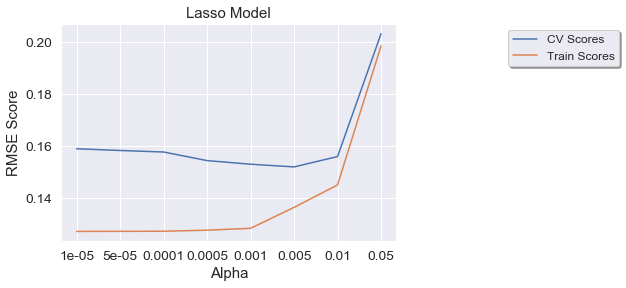

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot([str(x) for x in alpha_list], cv_scores_l, label = 'CV Scores')
plt.plot([str(x) for x in alpha_list], train_scores_l, label = 'Train Scores')
ax.legend(loc = 'upper center', bbox_to_anchor = (1.5, 1),
        fancybox = True, shadow = True, ncol = 1, prop = {'size': 12})
ax.set_xlabel('Alpha')
ax.set_ylabel('RMSE Score')
plt.title('Lasso Model')
plt.show()

## 4. 2. Stacking Model

Averaging Base Model

In [72]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [74]:
average_stacked_mod = AveragingModels(models = (GBoost, KRR, lasso))
scores, train_scores = ValRMSE(X_train, Y_train, average_stacked_mod, 5)
print("\nAverage Stacking score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))
print("\nAverage Stacking train score: {:.4f} ({:.4f})\n".format(
    train_scores.mean(), train_scores.std()))


Average Stacking score: 0.1407 (0.0153)


Average Stacking train score: 0.0995 (0.0021)



# 5. Submission

In [591]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
GBoost.fit(X_train, np.log(Y_train))
log_Y_pred = GBoost.predict(X_test)
Y_pred = np.exp(log_Y_pred)

In [592]:
log_Y_train_pred = GBoost.predict(X_train)

In [593]:
np.sqrt(np.average((log_Y_train_pred - np.log(Y_train))**2))

0.05470150058862553

In [444]:
sub = pd.DataFrame()
sub['Id'] = test_df['Id']
sub['SalePrice'] = Y_pred
sub.to_csv('GBoost_submission.csv',index=False)

In [75]:
Average = AveragingModels(models = (GBoost, KRR, lasso))
Average.fit(X_train, np.log(Y_train))
log_Y_pred = GBoost.predict(X_test)
Y_pred = np.exp(log_Y_pred)
sub = pd.DataFrame()
sub['Id'] = test_df['Id']
sub['SalePrice'] = Y_pred
sub.to_csv('Average_Stacking_submission.csv',index=False)